### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn import linear_model
import lightgbm as lgbm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


### Read files & submission file for template

In [2]:
X_train = pd.read_csv('X_train.csv',index_col='ROW_ID')
X_test = pd.read_csv('X_test.csv',index_col='ROW_ID')

y_train = pd.read_csv('y_train.csv',index_col='ROW_ID')
sample_submission = pd.read_csv('sample_submission.csv',index_col='ROW_ID')

In [3]:
X_train.columns

Index(['TS', 'ALLOCATION', 'RET_20', 'RET_19', 'RET_18', 'RET_17', 'RET_16',
       'RET_15', 'RET_14', 'RET_13', 'RET_12', 'RET_11', 'RET_10', 'RET_9',
       'RET_8', 'RET_7', 'RET_6', 'RET_5', 'RET_4', 'RET_3', 'RET_2', 'RET_1',
       'SIGNED_VOLUME_20', 'SIGNED_VOLUME_19', 'SIGNED_VOLUME_18',
       'SIGNED_VOLUME_17', 'SIGNED_VOLUME_16', 'SIGNED_VOLUME_15',
       'SIGNED_VOLUME_14', 'SIGNED_VOLUME_13', 'SIGNED_VOLUME_12',
       'SIGNED_VOLUME_11', 'SIGNED_VOLUME_10', 'SIGNED_VOLUME_9',
       'SIGNED_VOLUME_8', 'SIGNED_VOLUME_7', 'SIGNED_VOLUME_6',
       'SIGNED_VOLUME_5', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_3',
       'SIGNED_VOLUME_2', 'SIGNED_VOLUME_1', 'MEDIAN_DAILY_TURNOVER', 'GROUP'],
      dtype='object')

### Features

In [4]:
RET_features = [f'RET_{i}' for i in range(1,21)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1,21)]
TURNOVER_features = ['MEDIAN_DAILY_TURNOVER']

In [5]:
for i in [3,5,10,15,20]:
    X_train[ f'AVERAGE_PERF_{i}'] = X_train[RET_features[:i]].mean(1)
    X_train[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_train.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')
    
    X_test[ f'AVERAGE_PERF_{i}'] = X_test[RET_features[:i]].mean(1)
    X_test[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_test.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')

for i in [20]:
    X_train[ f'STD_PERF_{i}'] = X_train[RET_features[:i]].std(1)
    X_train[ f'ALLOCATIONS_STD_PERF_{i}'] = X_train.groupby('TS')[ f'STD_PERF_{i}'].transform('mean')
    
    X_test[ f'STD_PERF_{i}'] = X_test[RET_features[:i]].std(1)
    X_test[ f'ALLOCATIONS_STD_PERF_{i}'] = X_test.groupby('TS')[ f'STD_PERF_{i}'].transform('mean')


In [6]:
features = RET_features + SIGNED_VOLUME_features + TURNOVER_features
features = features + [ f'AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]
features = features + [ f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]
features = features + [ f'STD_PERF_{i}' for i in [20]]
features = features + [ f'ALLOCATIONS_STD_PERF_{i}' for i in [20]]

### Fitting one simple Ridge

In [7]:
new_ridge = linear_model.Ridge(alpha=1)

new_ridge.fit(X_train[features].to_numpy(na_value=0),y_train.to_numpy(na_value=0))

preds_ridge = pd.DataFrame(new_ridge.predict(X_test[features].fillna(0).to_numpy(na_value=0)), index = sample_submission.index,columns=['target'])

In [8]:
(preds_ridge>0).astype(int).to_csv('preds_ridge_bench.csv')

### Fitting a lightgbm using cross validation

In [9]:
features_lgbm = features

In [10]:

# A quite large number of trees with low depth to prevent overfits
lgbm_params = {
                "objective": "mse",
                "metric": "mse",
                "num_threads": 50,
                "seed": 42,
                "verbosity": -1,
                'learning_rate': 1e-2,
                'max_depth': 3,
}
NUM_BOOST_ROUND = 500

train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

n_splits = 8
scores_lgbm = []
models_lgbm = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True,).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['TS'].isin(local_train_dates)
    local_test_ids = X_train['TS'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids,[x for x in features_lgbm ]] 
    y_local_train = y_train.loc[local_train_ids,'target']
    
    X_local_test = X_train.loc[local_test_ids,[x for x in features_lgbm ]] 
    y_local_test = y_train.loc[local_test_ids,'target']
    
    X_local_train = X_local_train
    X_local_test = X_local_test

    train_data = lgbm.Dataset(X_local_train, label=y_local_train.values) 
    
    model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
    
    y_local_pred = model_lgbm.predict(X_local_test.values, num_threads = lgbm_params['num_threads'])
    
    
    models_lgbm.append(model_lgbm)
    score = accuracy_score((y_local_test>0).astype(int),
                (y_local_pred>0).astype(int))
    scores_lgbm.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores_lgbm)*100
std = np.std(scores_lgbm)*100

u = (mean + std)
l = (mean - std)

print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


Fold 1 - Accuracy: 51.95%
Fold 2 - Accuracy: 52.45%
Fold 3 - Accuracy: 52.18%
Fold 4 - Accuracy: 52.10%
Fold 5 - Accuracy: 51.97%
Fold 6 - Accuracy: 52.48%
Fold 7 - Accuracy: 52.45%
Fold 8 - Accuracy: 52.17%
Accuracy: 52.22% [52.02 ; 52.42] (+- 0.20)


<Axes: >

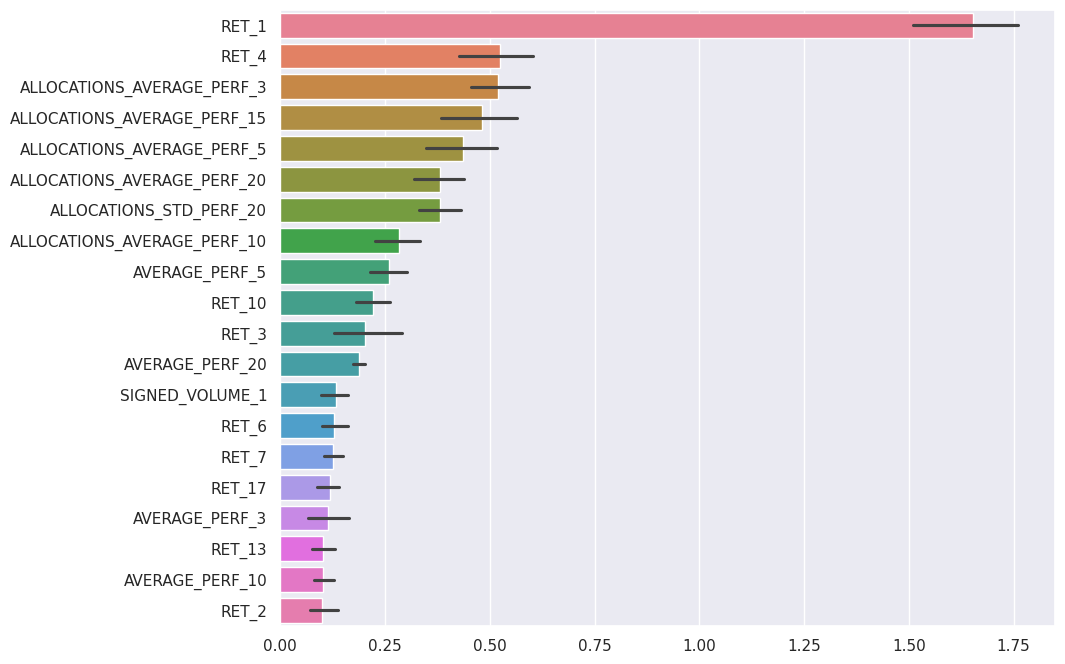

In [11]:
feature_importances = pd.DataFrame([model_lgbm.feature_importance(importance_type='gain') for model_lgbm in models_lgbm], columns=features_lgbm)

feature_importances = feature_importances.loc[:,feature_importances.mean(0).sort_values(ascending=False).index[:20]]

plt.figure(figsize=(10, 8))

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)


In [12]:
train_data = lgbm.Dataset(X_train[features_lgbm], label=y_train) 

model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
preds_lgbm = model_lgbm.predict(X_test[features_lgbm])
preds_lgbm = pd.DataFrame(preds_lgbm, index=sample_submission.index,columns=['target']) 


In [13]:
(preds_lgbm>0).astype(int).to_csv('preds_lgbm_bench.csv')